# Star Tracking
## Detection in high electrical and luminous noise

Importing the libraries

In [2]:
import matplotlib.pyplot as plt
import cv2
import os
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

Installing skimage to compute peak local maxima

In [3]:
!pip install scikit-image


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\anjel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Installing gdown to import the image repositories

In [4]:
!pip install gdown
import gdown


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\anjel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Importing the repository with all the images on which we will work

In [5]:
path = os.getcwd()
print("Your current path", path)
files = os.listdir(path)
print("Files in the current directory:", files)


Your current path c:\Users\anjel\Desktop\Image project\project
Files in the current directory: ['Star Tracking.ipynb', 'Star_images', 'Star_images.zip']


Downloading the repository with the images

In [6]:
# Inserisci l’ID del file condiviso
file_id = "1yGgAPiegBl9IBCPWQeXmOKNFGsyhw6MW"
url = f"https://drive.google.com/uc?id={file_id}"

# Scarica nella cartella corrente
output = "Star_images.zip"
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1yGgAPiegBl9IBCPWQeXmOKNFGsyhw6MW
To: c:\Users\anjel\Desktop\Image project\project\Star_images.zip
100%|██████████| 6.10M/6.10M [00:00<00:00, 7.77MB/s]


'Star_images.zip'

Unzipping the repository

In [7]:
import zipfile

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(".")   # "." = cartella corrente
print("The repository has been unzipped successfully.")

The repository has been unzipped successfully.


In [8]:
image_path = "./Star_images"
# Elenco di tutti i file immagine (jpg, png, ecc.)
files = [f for f in os.listdir(image_path) if f.lower().endswith(('.png'))]

print(f"{len(files)} images founded:")
for f in files:
    print("-", f)

8 images founded:
- 0_perfect_annotation.png
- 1 perfect.png
- 2 zero_noise.png
- 3 little_noise.png
- 4 more_noise.png
- 5 dark_current.png
- 6 blur.png
- 7 blurr_current_noise.png


Checking the images we have downloaded

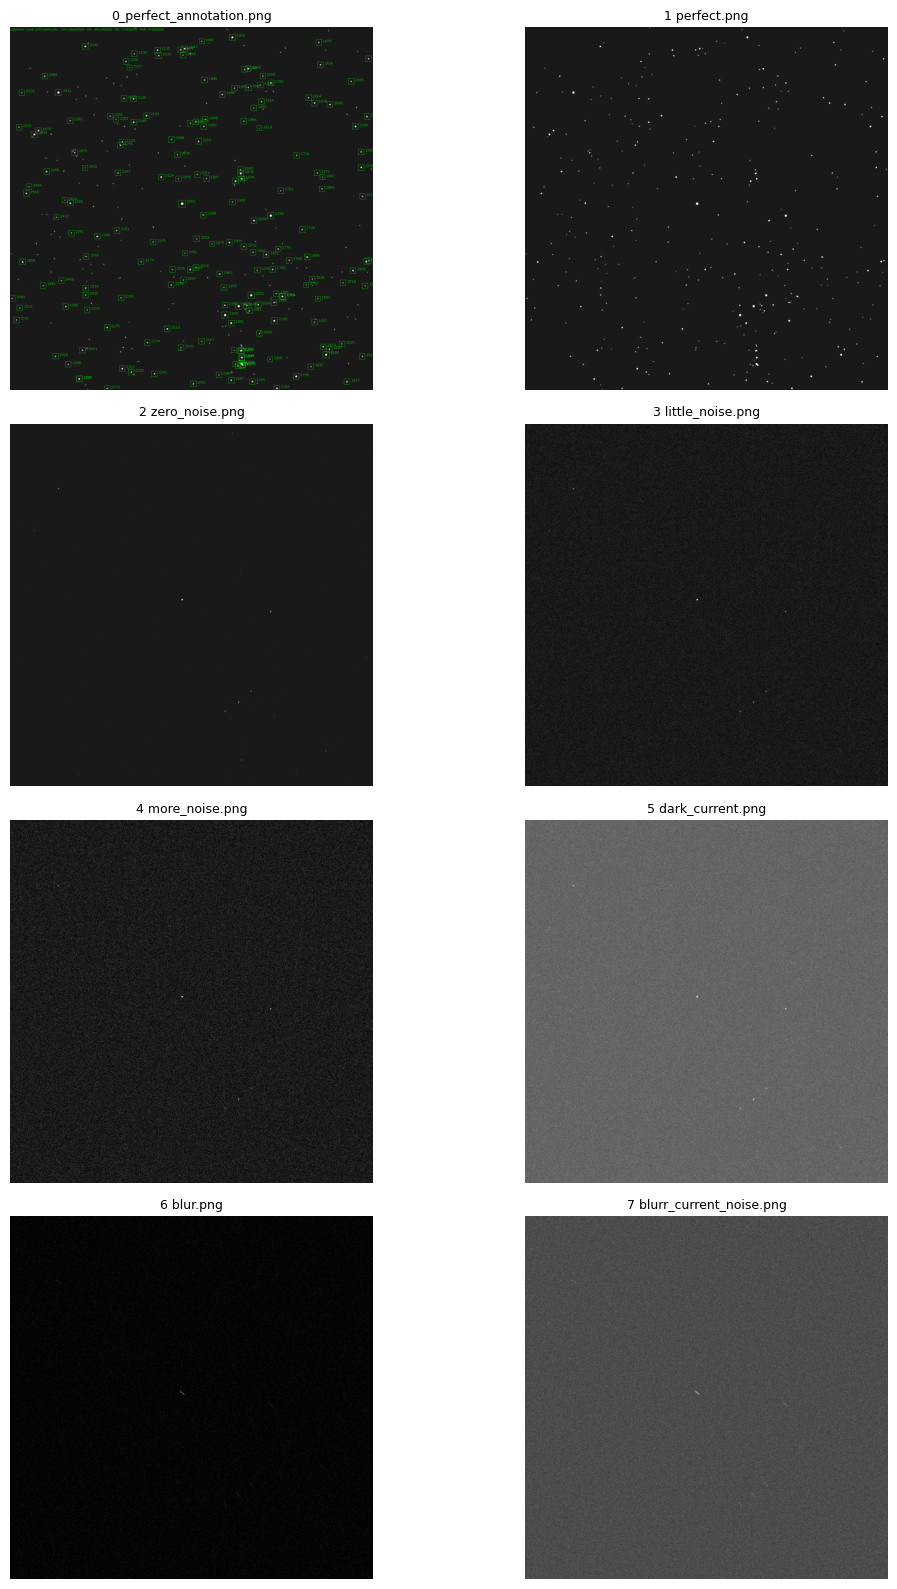

In [9]:
cols = 2  # images per line
rows = math.ceil(len(files) / cols)

plt.figure(figsize=(12, 4 * rows))

for i, file in enumerate(files):
    img = cv2.imread(os.path.join(image_path, file))

    if img is None:
        raise FileNotFoundError(f"Image not found or failed to load: {image_path}")


    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_rgb)
    plt.title(file, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


## The final goal

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

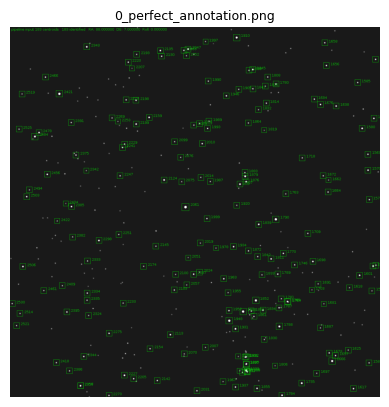

In [10]:
img = cv2.imread(os.path.join(image_path, "0_perfect_annotation.png"))

if img is None:
    raise FileNotFoundError(f"Image not found or failed to load: {image_path}")


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("0_perfect_annotation.png", fontsize=9)
plt.axis('off')

The picture above is the result of a star detection analisys made by the program lost (add mor information about it).
Notice that in this detection process, some of the stars were not correctly identified (look at the one not in the green rectangle). The final goal of this project is to perfection the detection process to increase the number of correct detection and to keep the same detection quality on different kind of images, in high noise situation or in clean ones.

## Analyzing the perfect image

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

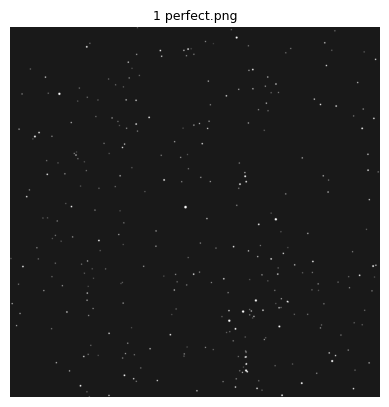

In [11]:
img = cv2.imread(os.path.join(image_path, "1 perfect.png"))

if img is None:
    raise FileNotFoundError(f"Image not found or failed to load: {image_path}")


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("1 perfect.png", fontsize=9)
plt.axis('off')

In the image analized by the lost program, almost all stars are visible at the human eye. The contrast is quite high. So a good idea to increment the lightining difference in between the sky and stars would be to use a threshold value. 
Let's go step by step:

First of all, let's convert the image from BGR format to shades of gray

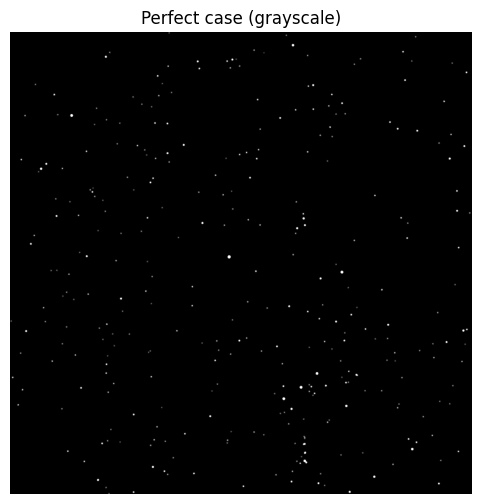

In [12]:
gray_img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,6))

plt.imshow(gray_img, cmap='gray')
plt.title("Perfect case (grayscale)")
plt.axis('off')
plt.show()


The contrast in light in between sky and stars in this case is quite high, infact:

In [13]:
# Ottieni dimensioni
rows, cols = gray_img.shape

# Crea una griglia di coordinate (X = colonne, Y = righe)
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

# Z corrisponde alla luminosità del pixel
Z = gray_img


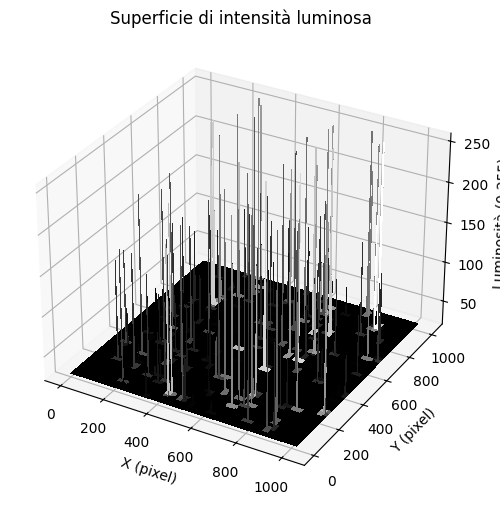

In [14]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Visualizza la superficie 3D
ax.plot_surface(X, Y, Z, cmap='gray', linewidth=0, antialiased=False)

ax.set_xlabel('X (pixel)')
ax.set_ylabel('Y (pixel)')
ax.set_zlabel('Luminosità (0-255)')
ax.set_title('Superficie di intensità luminosa')

plt.show()


In [15]:
print("Valore minimo:", gray_img.min())
print("Valore massimo:", gray_img.max())

Valore minimo: 25
Valore massimo: 255


The fact that the minimum value is 25, which is the background, means that we can use whatever value above it to define a star

We can detect as a star whatever has a light level higher than 0 because in this case we have 0 noise.
To distinguish one star from another we will use the countur method, associating multiple adjacent pixels to the same star.

In [16]:
#Detect only stars within certain dimensions
def detect_stars(frame):
    contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    stars = []
    for c in contours:
        M = cv2.moments(c)
        if M["m00"] > 0:
            cx = int(M["m10"]/M["m00"])
            cy = int(M["m01"]/M["m00"])
            stars.append((cx, cy))
    return np.array(stars)

Before using this function we need just one more step, which is using a threshold to set all the pixel of light higher than it, to white. In fact the function findContours works on binary levels 0 (background) 255 (object).

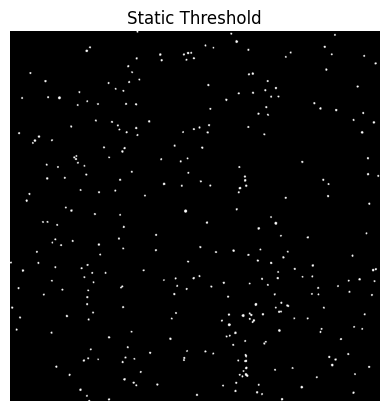

In [17]:
_, binary = cv2.threshold(gray_img, 30, 255, cv2.THRESH_BINARY)
plt.imshow(binary, cmap='gray')
plt.title("Static Threshold")
plt.axis('off')
plt.show()

Rilevate 315 stelle


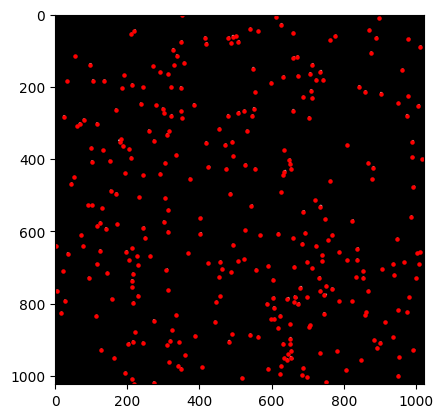

In [18]:
stars = detect_stars(binary)
print(f"Rilevate {len(stars)} stelle")
plt.imshow(binary, cmap='gray')
plt.scatter(stars[:,0], stars[:,1], c='red', s=5)
plt.show()

We can see that all the stars of the initial picture are now being detected

## Atmosphere noise

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

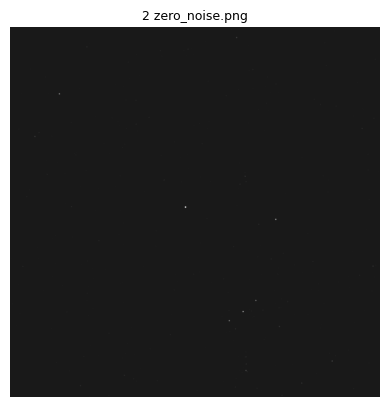

In [19]:
img = cv2.imread(os.path.join(image_path, "2 zero_noise.png"))

if img is None:
    raise FileNotFoundError(f"Image not found or failed to load: {image_path}")


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("2 zero_noise.png", fontsize=9)
plt.axis('off')

As we can see, by only adding the atmosphere layer the quality of the image goes down to a much lower value. Here we need to adjust and refine some of the previous step.

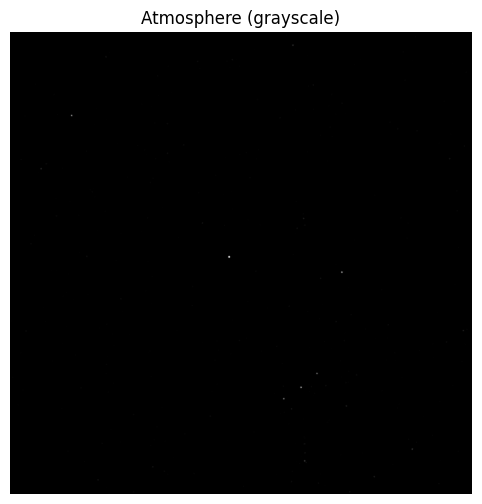

In [20]:
gray_img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,6))

plt.imshow(gray_img, cmap='gray')
plt.title("Atmosphere (grayscale)")
plt.axis('off')
plt.show()


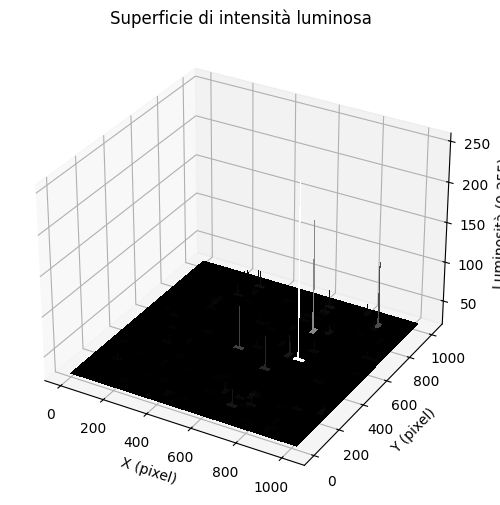

In [21]:
# Ottieni dimensioni
rows, cols = gray_img.shape

# Crea una griglia di coordinate (X = colonne, Y = righe)
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

# Z corrisponde alla luminosità del pixel
Z = gray_img
 
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Visualizza la superficie 3D
ax.plot_surface(X, Y, Z, cmap='gray', linewidth=0, antialiased=False)

ax.set_xlabel('X (pixel)')
ax.set_ylabel('Y (pixel)')
ax.set_zlabel('Luminosità (0-255)')
ax.set_title('Superficie di intensità luminosa')

plt.show()


In [22]:
print("Valore minimo:", gray_img.min())
print("Valore massimo:", gray_img.max())

Valore minimo: 25
Valore massimo: 255


Thresholding here would not have the same effect as it previously did, because the light contrast is not high for every star, in contrast, many of the stars are now hidden by the atmosphere in the darker values. Lowering the treshold to the immediate next value with respect to the minimum one, from 25 to 26, is not really a good option. If we do it we do se any more stars with respect to the ones that we can see by keeping the same threshold than before, but we might end up in errors of detection, detecting pixel belonging to the background, but a bit lighter, as stars. This is never a good option. (controlla bene)

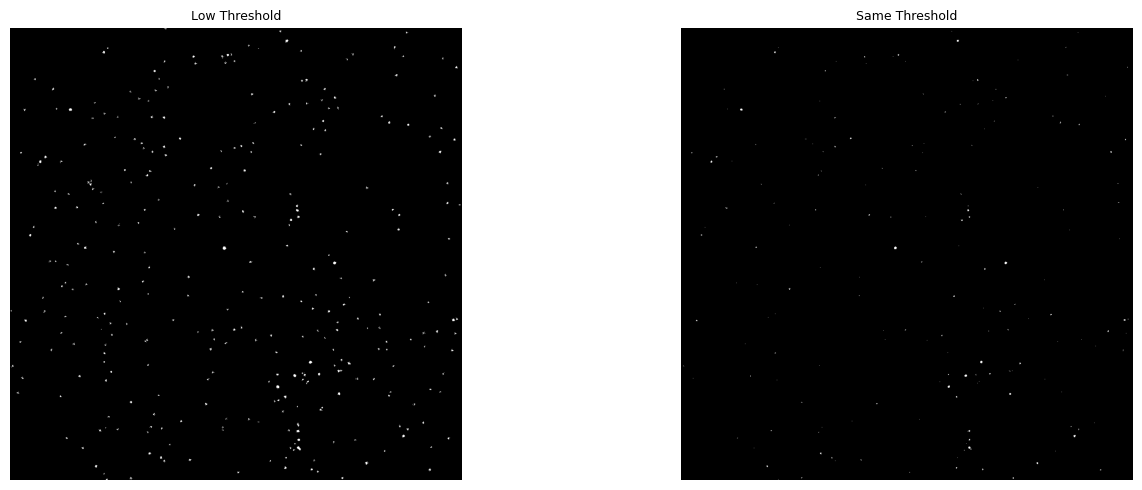

<Figure size 640x480 with 0 Axes>

In [23]:
_, binary_low = cv2.threshold(gray_img, 26, 255, cv2.THRESH_BINARY)
_, binary_same = cv2.threshold(gray_img, 30, 255, cv2.THRESH_BINARY)
# ...existing code...
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(binary_low, cmap='gray')
axes[0].set_title("Low Threshold", fontsize=9)
axes[0].axis('off')

axes[1].imshow(binary_same, cmap='gray')
axes[1].set_title("Same Threshold", fontsize=9)
axes[1].axis('off')

plt.tight_layout()
plt.show()
# ...existing code...

plt.tight_layout()
plt.show()

Let's use a logarithmic scale together with contrastant shades of color to better visualize the different of level of light among the pixels of the image

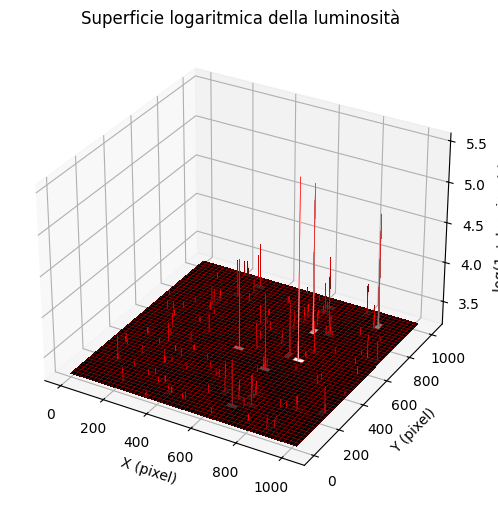

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Evita log(0) aggiungendo un piccolo offset
Z_log = np.log1p(Z)  # log(1 + Z)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Grafico della superficie logaritmica
ax.plot_surface(X, Y, Z_log, cmap='gray', linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, np.log1p(Z),
                       cmap='gray',
                       edgecolor='red',
                       linewidth=0.2,
                       shade=True)

ax.set_xlabel('X (pixel)')
ax.set_ylabel('Y (pixel)')
ax.set_zlabel('log(1 + Luminosità)')
ax.set_title('Superficie logaritmica della luminosità')

plt.show()


All of these are the stars detected

Numero di picchi rilevati: 312


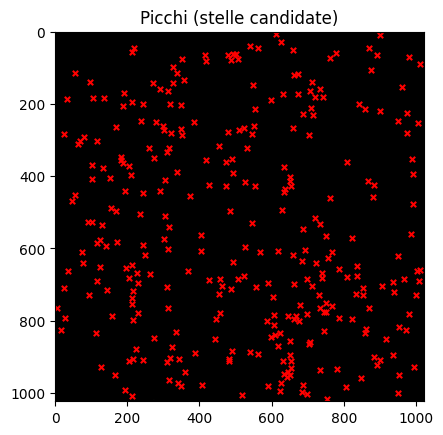

In [25]:
from skimage.feature import peak_local_max

# Trova i picchi (stelle) sull’immagine grigia
coordinates = peak_local_max(gray_img, min_distance=5, threshold_abs=25)

print("Numero di picchi rilevati:", len(coordinates))

# Visualizza
plt.imshow(gray_img, cmap='gray')
plt.scatter(coordinates[:, 1], coordinates[:, 0], c='r', s=15, marker='x')
plt.title("Picchi (stelle candidate)")
plt.show()


# VALUTA SE INSERIRE

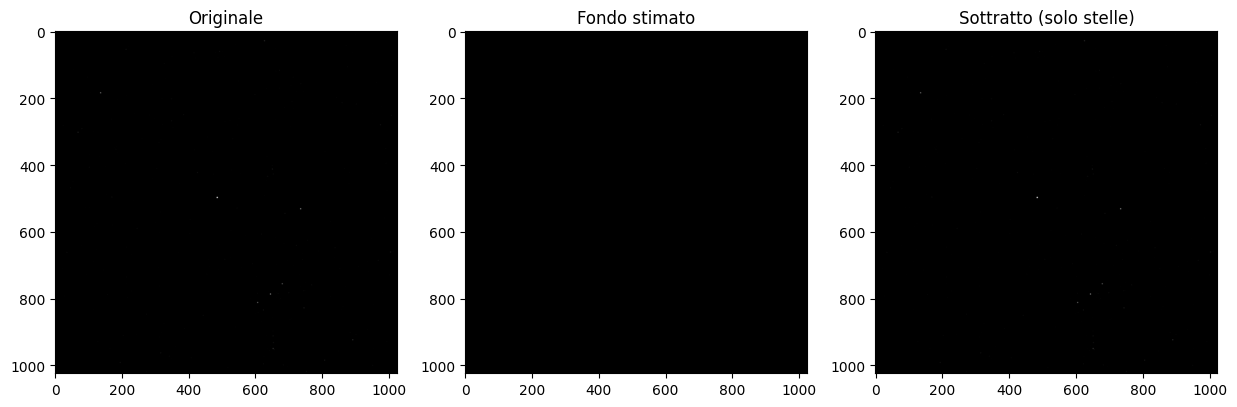

In [26]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Filtro morfologico per stimare il fondo (rimuove oggetti piccoli come stelle)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25))
background = cv2.morphologyEx(gray_img, cv2.MORPH_OPEN, kernel)

# Sottrai il fondo
foreground = cv2.subtract(gray_img, background)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(gray_img, cmap='gray'); plt.title("Originale")
plt.subplot(1,3,2); plt.imshow(background, cmap='gray'); plt.title("Fondo stimato")
plt.subplot(1,3,3); plt.imshow(foreground, cmap='gray'); plt.title("Sottratto (solo stelle)")
plt.show()


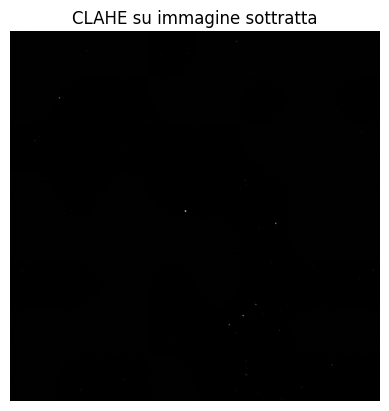

In [27]:
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced = clahe.apply(gray_img)

plt.imshow(enhanced, cmap='gray')
plt.title("CLAHE su immagine sottratta")
plt.axis('off')
plt.show()


Rilevate 315 stelle


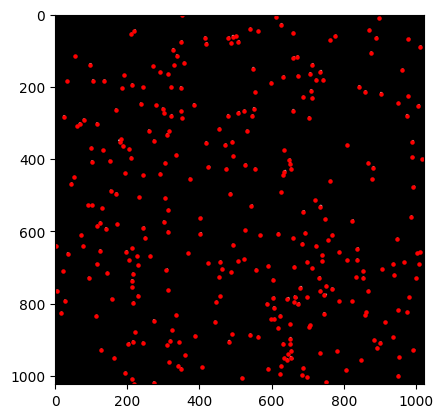

In [28]:
stars = detect_stars(binary)
print(f"Rilevate {len(stars)} stelle")
plt.imshow(binary, cmap='gray')
plt.scatter(stars[:,0], stars[:,1], c='red', s=5)
plt.show()

# FINE SEZIONE

## Adding some electric noise

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

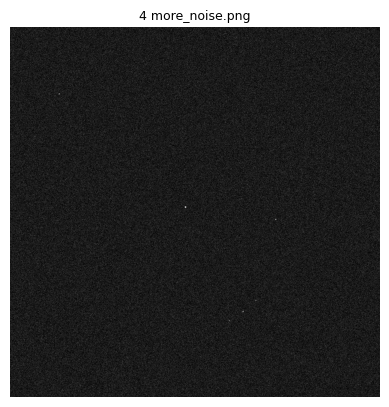

In [29]:
img = cv2.imread(os.path.join(image_path, "4 more_noise.png"))

if img is None:
    raise FileNotFoundError(f"Image not found or failed to load: {image_path}")


gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_img, cmap='gray')
plt.title("4 more_noise.png", fontsize=9)
plt.axis('off')

Numero di picchi rilevati: 8797


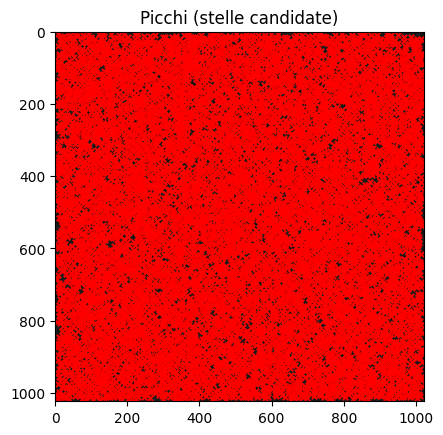

In [30]:
from skimage.feature import peak_local_max

# Trova i picchi (stelle) sull’immagine grigia
coordinates = peak_local_max(gray_img, min_distance=5, threshold_abs=26)

print("Numero di picchi rilevati:", len(coordinates))

# Visualizza
plt.imshow(gray_img, cmap='gray')
plt.scatter(coordinates[:, 1], coordinates[:, 0], c='r', s=15, marker='x')
plt.title("Picchi (stelle candidate)")
plt.show()


As visible the previous method is no longer working on this image. This is due to it's light variance graph, infact:

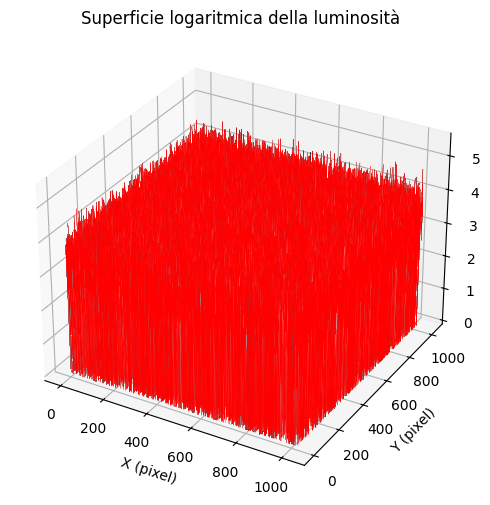

In [31]:

# Ottieni dimensioni
rows, cols = gray_img.shape

# Crea una griglia di coordinate (X = colonne, Y = righe)
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

# Z corrisponde alla luminosità del pixel
Z = gray_img
 
# Evita log(0) aggiungendo un piccolo offset
Z_log = np.log1p(Z)  # log(1 + Z)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Grafico della superficie logaritmica
ax.plot_surface(X, Y, Z_log, cmap='gray', linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, np.log1p(Z),
                       cmap='gray',
                       edgecolor='red',
                       linewidth=0.2,
                       shade=True)

ax.set_xlabel('X (pixel)')
ax.set_ylabel('Y (pixel)')
ax.set_zlabel('log(1 + Luminosità)')
ax.set_title('Superficie logaritmica della luminosità')

plt.show()


This is horrible

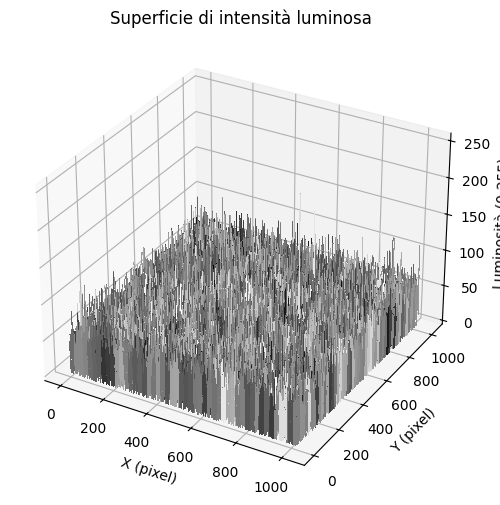

In [32]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Visualizza la superficie 3D
ax.plot_surface(X, Y, Z, cmap='gray', linewidth=0, antialiased=False)

ax.set_xlabel('X (pixel)')
ax.set_ylabel('Y (pixel)')
ax.set_zlabel('Luminosità (0-255)')
ax.set_title('Superficie di intensità luminosa')

plt.show()


How to work on it in this case?

What was useful before was that each white section was well distantiated from the other, making it easy to distinguish about being stars. Now, with the noise, we have intermitted white pixel even though they are not stars. To differ from noise to stars we need to add a new information and to understand the nature of the noise in order to use the right filter.

In [33]:
average_val = np.mean(gray_img)
print("Luminosità media:", average_val)

Luminosità media: 26.63798999786377


In [34]:
# Numero di pixel nel range medio ± tolleranza
mask = (gray_img >= 0) & (gray_img <= average_val + 2)
num_in_range = np.count_nonzero(mask)

# Totale pixel
total_pixels = gray_img.size

# Percentuale
percentage = (num_in_range / total_pixels) * 100

print(f"Pixel con luminosità ~{average_val:.2f}: {percentage:.2f}% dell'immagine")


Pixel con luminosità ~26.64: 56.02% dell'immagine


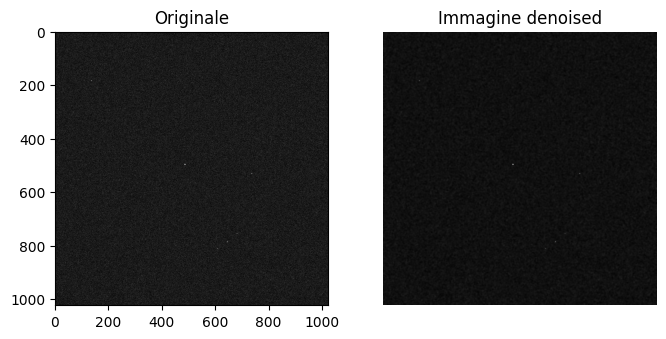

In [45]:
denoised = cv2.bilateralFilter(gray_img, 9, 50, 100)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(gray_img, cmap='gray'); plt.title("Originale")
plt.subplot(1,3,2); plt.imshow(denoised, cmap='gray'); plt.title("Immagine denoised")
plt.axis('off')
plt.show()

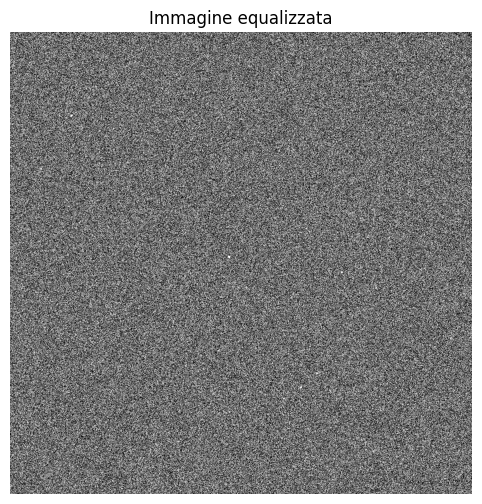

In [36]:
Z_eq = cv2.equalizeHist(Z)
plt.figure(figsize=(8,6))
plt.imshow(Z_eq, cmap='gray')
plt.title('Immagine equalizzata')
plt.axis('off')
plt.show()


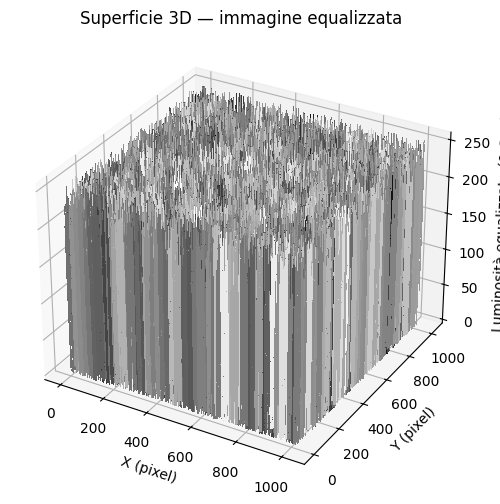

In [37]:
rows, cols = Z_eq.shape
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

# Grafico 3D dell’immagine equalizzata
ax.plot_surface(X, Y, Z_eq, cmap='gray', linewidth=0, antialiased=False)

ax.set_xlabel('X (pixel)')
ax.set_ylabel('Y (pixel)')
ax.set_zlabel('Luminosità equalizzata (0–255)')
ax.set_title('Superficie 3D — immagine equalizzata')

plt.show()


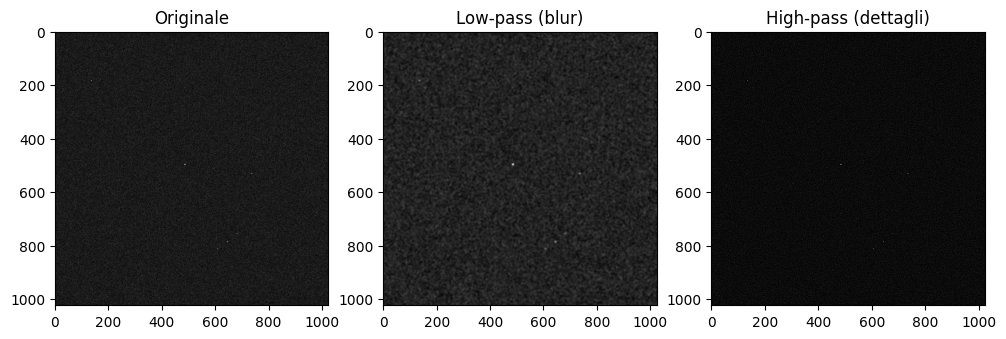

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Crea una versione sfocata (low-pass)
blur = cv2.GaussianBlur(gray_img, (15, 15), 0)

# Sottrai la componente a bassa frequenza
highpass = cv2.subtract(gray_img, blur)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(gray_img, cmap='gray'); plt.title("Originale")
plt.subplot(1,3,2); plt.imshow(blur, cmap='gray'); plt.title("Low-pass (blur)")
plt.subplot(1,3,3); plt.imshow(highpass, cmap='gray'); plt.title("High-pass (dettagli)")
plt.show()


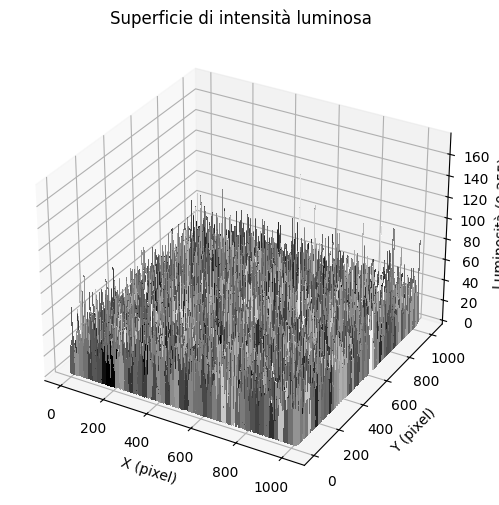

In [39]:
# Ottieni dimensioni
rows, cols = highpass.shape

# Crea una griglia di coordinate (X = colonne, Y = righe)
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

# Z corrisponde alla luminosità del pixel
Z = highpass
 
# Evita log(0) aggiungendo un piccolo offset
Z_log = np.log1p(Z)  # log(1 + Z)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Visualizza la superficie 3D
ax.plot_surface(X, Y, Z, cmap='gray', linewidth=0, antialiased=False)

ax.set_xlabel('X (pixel)')
ax.set_ylabel('Y (pixel)')
ax.set_zlabel('Luminosità (0-255)')
ax.set_title('Superficie di intensità luminosa')

plt.show()


plt.show()


In [40]:
average_val = np.mean(highpass)
print("Luminosità media:", average_val)

# Numero di pixel nel range medio ± tolleranza
mask = (highpass >= 0) & (highpass <= average_val + 2)
num_in_range = np.count_nonzero(mask)

# Totale pixel
total_pixels = highpass.size

# Percentuale
percentage = (num_in_range / total_pixels) * 100

print(f"Pixel con luminosità ~{average_val:.2f}: {percentage:.2f}% dell'immagine")


Luminosità media: 8.232830047607422
Pixel con luminosità ~8.23: 70.37% dell'immagine


Numero di picchi rilevati: 304


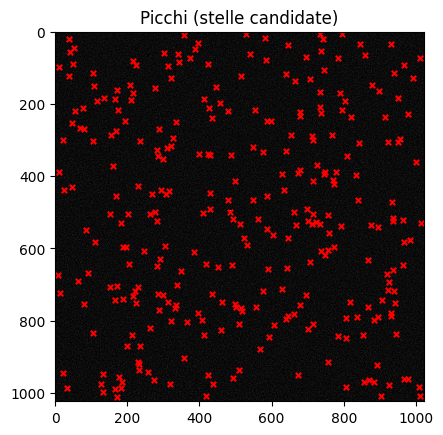

In [41]:
# Trova i picchi (stelle) sull’immagine grigia
coordinates = peak_local_max(highpass, min_distance=5, threshold_abs=75)        #perchè? Calcola valori più presenti di luminosità

print("Numero di picchi rilevati:", len(coordinates))

# Visualizza
plt.imshow(highpass, cmap='gray')
plt.scatter(coordinates[:, 1], coordinates[:, 0], c='r', s=15, marker='x')
plt.title("Picchi (stelle candidate)")
plt.show()
